# Importing packages and data

In [61]:
# General packages
import matplotlib
import pathlib
import numpy as np
import pandas as pd
import math
import pickle
import copy
import csv
import multiprocess as mp

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import transforms
import matplotlib.pylab as pylab
from pylab import *
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# Correlations
import pingouin as pg
from scipy import stats
import dcor

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup

## Load the data

In [10]:
# Loading the Welch's PSDs and the one over f properties:
# for the frequency analysis
welch_all = np.load('Welch_all.npy',allow_pickle = True)
fg_all = np.load('fg_all.npy',allow_pickle = True)
# for the one over f analysis
welch_all_time = np.load('Welch_time_all_1Hz_2s.npy',allow_pickle = True)
fg_time_all = np.load('fg_time_all_1Hz_2s.npy',allow_pickle = True)

# Individual characteristics (age and UPDRS)
data_charac = np.load('data_charac.npy',allow_pickle = True)

# Loading the center of mass coordinates of the brain 44 regions projected on 2 dimensions (x,y)
x = load('proj_brain_x.npy')
y = load('proj_brain_y.npy')

# Frequency sampling
fs = 200

### Brain region names

In [7]:
HCP_labels = ["Anterior Cingulate and Medial Prefrontal Cortex-lh","Anterior Cingulate and Medial Prefrontal Cortex-rh","Auditory Association Cortex-lh","Auditory Association Cortex-rh","Dorsal Stream Visual Cortex-lh","Dorsal Stream Visual Cortex-rh","DorsoLateral Prefrontal Cortex-lh","DorsoLateral Prefrontal Cortex-rh","Early Auditory Cortex-lh","Early Auditory Cortex-rh","Early Visual Cortex-lh","Early Visual Cortex-rh","Inferior Frontal Cortex-lh","Inferior Frontal Cortex-rh","Inferior Parietal Cortex-lh","Inferior Parietal Cortex-rh","Insular and Frontal Opercular Cortex-lh","Insular and Frontal Opercular Cortex-rh","Lateral Temporal Cortex-lh","Lateral Temporal Cortex-rh","MT+ Complex and Neighboring Visual Areas-lh","MT+ Complex and Neighboring Visual Areas-rh","Medial Temporal Cortex-lh","Medial Temporal Cortex-rh","Orbital and Polar Frontal Cortex-lh","Orbital and Polar Frontal Cortex-rh","Paracentral Lobular and Mid Cingulate Cortex-lh","Paracentral Lobular and Mid Cingulate Cortex-rh","Posterior Cingulate Cortex-lh","Posterior Cingulate Cortex-rh","Posterior Opercular Cortex-lh","Posterior Opercular Cortex-rh","Premotor Cortex-lh","Premotor Cortex-rh","Primary Visual Cortex (V1)-lh","Primary Visual Cortex (V1)-rh","Somatosensory and Motor Cortex-lh","Somatosensory and Motor Cortex-rh","Superior Parietal Cortex-lh","Superior Parietal Cortex-rh","Temporo-Parieto-Occipital Junction-lh","Temporo-Parieto-Occipital Junction-rh","Ventral Stream Visual Cortex-lh","Ventral Stream Visual Cortex-rh"]
HCP_labels_abrv = ["AC-MPC-lh","AC-MPC-rh","AAC-lh","AAC-rh","DSVC-lh","DSVC-rh","DPC-lh","DPC-rh","EAC-lh","EAC-rh","EVC-lh","EVC-rh","IFC-lh","IFC-rh","IPC-lh","IPC-rh","I-FOC-lh","I-FOC-rh","LTC-lh","LTC-rh","MT+C-NVA-lh","MT+C-NVA-rh","MTC-lh","MTC-rh","O-PFC-lh","O-PFC-rh","PL-MCC-lh","PL-MCC-rh","PCC-lh","PCC-rh","POC-lh","POC-rh","PMC-lh","PMC-rh","PVC-V1-lh","PVC-V1-rh","SMC-lh","SMC-rh","SPC-lh","SPCrh","T-P-O-J-lh","T-P-O-J-rh","VSVC-lh","VSVC-rh"]
labnam = ["AC-MPC","AAC","DSVC","DPC","EAC","EVC","IFC","IPC","I-FOC","LTC","MT+C-NVA","MTC","O-PFC","PL-MCC","PCC","POC","PMC","PVC-V1","SMC","SPC","T-P-O-J","VSVC"]
HCP_labels_no_hemi = ["Anterior Cingulate and Medial Prefrontal Cortex","Auditory Association Cortex","Dorsal Stream Visual Cortex","DorsoLateral Prefrontal Cortex","Early Auditory Cortex","Early Visual Cortex","Inferior Frontal Cortex","Inferior Parietal Cortex","Insular and Frontal Opercular Cortex","Lateral Temporal Cortex","MT+ Complex and Neighboring Visual Areas","Medial Temporal Cortex","Orbital and Polar Frontal Cortex","Paracentral Lobular and Mid Cingulate Cortex","Posterior Cingulate Cortex","Posterior Opercular Cortex","Premotor Cortex","Primary Visual Cortex (V1","Somatosensory and Motor Cortex","Superior Parietal Cortex","Temporo-Parieto-Occipital Junction","Ventral Stream Visual Cortex"]


## Extract the data used in the following (mean, std, fit error...)

In [11]:
def data_extraction(welch_all_time,fg_time_all,fg_all,data_charac,age_sort):
    """
    Extracting different statistics from the data: mean, standard deviation...
    
    welch_all_time: list of Welch's PSD as a spectrogram (list of matrices)
    fg_all_time: list of FOOOF results when applied to the Welch's spectrogram 'welch_all_time'
    fg_all: list of FOOOF results when applied to the Welch's PSD (list of vectors)
    data_charac: individual characteristics (age and UPDRS)
    age_sort: if equal to one, data are ordered according to the age
    """
    # Initialisation
    ages = [ [] for i in range(2) ]
    UPDRS = [ [] for i in range(2) ]
    exps_time_all = [ [] for i in range(4) ]
    exps_all = [ [] for i in range(4) ]
    offset_all = [ [] for i in range(4) ]
    error_time_all = [ [] for i in range(4) ]
    Rsquare_time_all = [ [] for i in range(4) ]
    peaks_time_all = [ [] for i in range(4) ]
    peaks_all = [ [] for i in range(4) ]
    mean_exps = [ [] for i in range(4) ]
    std_exps = [ [] for i in range(4) ]
    diff_init_end = [ [] for i in range(4) ]
    spearman_corr_time = [ [] for i in range(4) ]
    mean_Rsquare = [ [] for i in range(4) ]
    new_welch = [ [ [] for j in range(0,len(welch_all_time[i]))] for i in range(0,4)]
    
    # age and UPDRS data
    ages[0] = data_charac[data_charac[:,0]==0,1]
    ages[1] = data_charac[data_charac[:,0]==1,1]
    UPDRS[0] = data_charac[data_charac[:,0]==0,5]
    UPDRS[1] = data_charac[data_charac[:,0]==0,4]
    ind_age_PD = argsort(ages[0])
    ind_age_HC = argsort(ages[1])
    
    # variables used to remove the power law from the original PSD
    delta_f = fs/(2*(welch_all_time[0][0][0].shape[0]-1))
    f_welch = arange( 0., fs/2+delta_f, delta_f )
    f_lo = 1
    f_hi = 45
    f_ind = (f_welch >= f_lo) & (f_welch <= f_hi)
    
    # filling the variables
    for i in range(0,4):
        if age_sort==1:
            if i<2 : ind = ind_age_PD
            else : ind = ind_age_HC
        else : ind = arange(0,len(fg_time_all[i]))
        for j in range(0,len(fg_time_all[i])):
            time_welch = welch_all_time[i][ind[j]][0].shape[1]
            exps = zeros((44,time_welch))
            errors = zeros((44,time_welch))
            Rsquares = zeros((44,time_welch))
            spearmans = zeros((44,1))
            peaks = []
            for k in range(0,44):
                exps[k,:] = fg_time_all[i][ind[j]][k].get_params('aperiodic_params', 'exponent')
                errors[k,:] = fg_time_all[i][ind[j]][k].get_params('error')
                Rsquares[k,:] = fg_time_all[i][ind[j]][k].get_params('r_squared')
                peaks.append( fg_time_all[i][ind[j]][k].get_params('peak_params') )
                spearmans[k], pval = stats.spearmanr(exps[k,:], arange(0,time_welch))
                abs_p = fg_time_all[i][ind[j]][k].get_params('aperiodic_params', 'offset')
                new_welch[i][j].append((welch_all_time[i][ind[j]][k] - 10**(abs_p)/(f_welch[:,None] ** exps[k,:].T))[f_ind,:])
            exps_time_all[i].append(exps)
            exps_all[i].append(fg_all[i][ind[j]].get_params('aperiodic_params', 'exponent'))
            offset_all[i].append(fg_all[i][ind[j]].get_params('aperiodic_params', 'offset'))
            peaks_all[i].append(fg_all[i][ind[j]].get_params('peak_params'))
            error_time_all[i].append(errors)
            Rsquare_time_all[i].append(Rsquares)
            peaks_time_all[i].append(peaks)
            mean_exps[i].append(exps_time_all[i][j].mean(1))
            std_exps[i].append(exps_time_all[i][j].std(1))
            diff_init_end[i].append(exps_time_all[i][j][:,0] - exps_time_all[i][j][:,-1])
            spearman_corr_time[i].append(spearmans)
            mean_Rsquare[i].append(Rsquare_time_all[i][j].mean(1))
    
    # age sorting of age and UPDRS 
    if age_sort==1:
        UPDRS[0] = UPDRS[0][ind_age_PD]
        UPDRS[1] = UPDRS[1][ind_age_PD]
        ages[0] = ages[0][ind_age_PD]
        ages[1] = ages[1][ind_age_HC]
        
    return new_welch,mean_Rsquare,spearman_corr_time,exps_all,offset_all,exps_time_all,error_time_all,Rsquare_time_all,peaks_all, peaks_time_all,mean_exps,std_exps,diff_init_end,ages,UPDRS

    

In [12]:
new_welch,mean_Rsquare,spearman_corr_time,exps_all,offset_all,exps_time_all,error_time_all,Rsquare_time_all,peaks_all,peaks_time_all,mean_exps,std_exps,diff_init_end,ages,UPDRS = data_extraction(welch_all_time,fg_time_all,fg_all,data_charac,1)


/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/3332847175.py:63: RuntimeWarning: divide by zero encountered in true_divide
  new_welch[i][j].append((welch_all_time[i][ind[j]][k] - 10**(abs_p)/(f_welch[:,None] ** exps[k,:].T))[f_ind,:])


# FUNCTIONS

## Technical functions

In [13]:
def round_decimals_down(number:float, decimals:int=2):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

In [14]:
def remove_sev(list_to_chg,elem_to_remove):
    """
    Returns list_to_chg without the elem_to_remove
    """
    return [e for e in list_to_chg if e not in elem_to_remove]

## Used for plotting

In [15]:
def min_max_diff(l_mean, l_std, l_diff, diff_type='std'):
    """
    Computing the differences between variables and their min and max values
    
    l_mean: list of vectors (size 44 for 44 brain regions) to plot, color in the dots
    l_std: list of vectors (size 44 for 44 brain regions) to plot, color around the dots
    l_diff: list of integer defining which of the previous vectors must be substracted
    diff_type: method according to which the std of the differences are computed
    """
    n_m = len(l_mean)
    n_s = len(l_std)
    n_d = int( len(l_diff) / 2 )
    # We only keep brain regions for which there is no NAN in the data to plot
    ind_no_nan_mean = [isfinite(l_mean[k]) for k in range(0,n_m)]
    ind_no_nan_std = [isfinite(l_std[k]) for k in range(0,n_s)]
    ind_diff_mean = [ind_no_nan_mean[l_diff[2*k]] * ind_no_nan_mean[l_diff[2*k+1]] for k in range(0,n_d)]
    ind_diff_std = [ind_no_nan_std[l_diff[2*k]] * ind_no_nan_std[l_diff[2*k+1]] for k in range(0,n_d)]
    
    # Computing max and min of l_mean and l_std
    avg_min = min( min(l_mean[k][ind_no_nan_mean[k]]) for k in range(0,n_m) )
    avg_max = max( max(l_mean[k][ind_no_nan_mean[k]]) for k in range(0,n_m) )
    std_min = min( min(l_std[k][ind_no_nan_std[k]])  for k in range(0,n_s) )
    std_max = max( max(l_std[k][ind_no_nan_std[k]])  for k in range(0,n_s) )
    
    # Substracting elements of l_mean according to l_diff
    avg_diff_data = [ l_mean[l_diff[2*k]][ind_diff_mean[k]]-l_mean[l_diff[2*k+1]][ind_diff_mean[k]]  for k in range(0,n_d) ]
    avg_diff_min = min( min(avg_diff_data[k])  for k in range(0,n_d) )
    avg_diff_max = max( max(avg_diff_data[k])  for k in range(0,n_d) ) 
    
    # Computing std associated to avg_diff_data following different methods
    if diff_type == 'freq-diff':
        std_diff_data = [ (l_std[l_diff[2*k]][ind_diff_std[k]]-l_std[l_diff[2*k+1]][ind_diff_std[k]])/(l_std[l_diff[2*k]][ind_diff_std[k]]+l_std[l_diff[2*k+1]][ind_diff_std[k]]) for k in range(0,n_d) ]
        std_diff_min = min( min(std_diff_data[k])  for k in range(0,n_d) )
        std_diff_max = max( max(std_diff_data[k]) for k in range(0,n_d)  )
        std_diff = max( abs(std_diff_min), abs(std_diff_max) )
        std_diff_min = -std_diff
        std_diff_max = std_diff
    elif diff_type == 'freq':
        avg_diff_data = [l_mean[k][ind_no_nan_mean[k]] for k in range(3,6)]
        std_diff_data = [l_std[k][ind_no_nan_std[k]] for k in range(3,6)]
        avg_min = min( min(l_mean[k][ind_no_nan_mean[k]]) for k in range(0,3) )
        avg_max = max( max(l_mean[k][ind_no_nan_mean[k]]) for k in range(0,3) )
        std_min = min( min(l_std[k][ind_no_nan_std[k]])  for k in range(0,3) )
        std_max = max( max(l_std[k][ind_no_nan_std[k]])  for k in range(0,3) )
        avg_diff_min = min( min(l_mean[k][ind_no_nan_mean[k]]) for k in range(3,6) )
        avg_diff_max = max( max(l_mean[k][ind_no_nan_mean[k]]) for k in range(3,6) )
        std_diff_min = min( min(l_std[k][ind_no_nan_std[k]])  for k in range(3,6) )
        std_diff_max = max( max(l_std[k][ind_no_nan_std[k]])  for k in range(3,6) )
        avg_diff_data = [l_mean[k] for k in range(3,6)]
        std_diff_data = [l_std[k] for k in range(3,6)]
    else :
        std_diff_data = [ (l_std[l_diff[2*k]][ind_diff_std[k]]+l_std[l_diff[2*k+1]][ind_diff_std[k]])/2  for k in range(0,n_d) ]
        std_diff_min = min( min(std_diff_data[k])  for k in range(0,n_d) )
        std_diff_max = max( max(std_diff_data[k])  for k in range(0,n_d) )
    
    # when need of symmetric upper and lower bounds
    if diff_type != 'freq':
        avg_diff = max( abs(avg_diff_min), abs(avg_diff_max) )
        avg_diff_min = -avg_diff
        avg_diff_max = avg_diff
    
    return avg_diff_data, std_diff_data, avg_min, avg_max, std_min, std_max, avg_diff_min, avg_diff_max, std_diff_min, std_diff_max


In [16]:
# Create a new color map from dark greeen to gold with white in the middle
# (cmap to clearly see positive vs negative values)
from  matplotlib.colors import LinearSegmentedColormap
c = ["darkgreen","green","palegreen","white", "lemonchiffon","yellow","gold"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
diff_cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

In [17]:
def multiple_brain_plot_projection(x, y, avg_data, std_data, l_diff, title_, short_title, size_std_diff=20, type_col = 'std'):
    """
    2D plot of brain region characteristics on top of a brain image
    
    x,y: coordinates of the center of mass of brain regions
    avg_data: vector giving the mean value of a feature per brain region (color inside dots)
    std_data: vector giving the std value of a feature per brain region (color at the border of dots)
    l_diff: list of integer defining which of the previous vectors must be substracted
    title: give the group to which the data belongs to (PD ON, OFF, HC ...)
    short_title: used to save the figure
    size_std_diff: size of the text in the plots
    type_col: method determining the color of the dots
    """
    # Brain image in background
    img = plt.imread("brain_background.jpg")
    # Colors by default
    avg_cmap = 'viridis'
    std_cmap = cm.get_cmap('spring')
    avg_diff_cmap = 'seismic'
    std_diff_cmap = cm.get_cmap('summer')
    
    # Computing differences and bounds
    avg_diff_data, std_diff_data, avg_min, avg_max, std_min, std_max, avg_diff_min, avg_diff_max, std_diff_min, std_diff_max = min_max_diff(
        avg_data, std_data, l_diff)
    
    # Changing the colors, differences and bounds if needed
    if type_col == 'freq':
        avg_diff_cmap = 'viridis'
        std_diff_cmap = cm.get_cmap('spring')
        avg_diff_data, std_diff_data, avg_min, avg_max, std_min, std_max, avg_diff_min, avg_diff_max, std_diff_min, std_diff_max = min_max_diff(
            avg_data, std_data, l_diff, diff_type = 'freq')
        
    if type_col == 'freq-diff':
        std_diff_cmap = diff_cmap
        avg_diff_data, std_diff_data, avg_min, avg_max, std_min, std_max, avg_diff_min, avg_diff_max, std_diff_min, std_diff_max = min_max_diff(
            avg_data, std_data, l_diff, diff_type = 'freq-diff' )
    
    std_norm = matplotlib.colors.Normalize(vmin = std_min, vmax = std_max)
    std_diff_norm = matplotlib.colors.Normalize(vmin = std_diff_min, vmax = std_diff_max)
    
    if type_col == 'corr':
        std_cmap = mpl.colors.ListedColormap(['black', 'gray', 'lightgray'])
        std_norm = mpl.colors.BoundaryNorm([0,0.001,0.01,1.], std_cmap.N)
        avg_cmap = 'seismic'
        std_diff_cmap = mpl.colors.ListedColormap(['black', 'gray', 'lightgray'])
        std_diff_norm = mpl.colors.BoundaryNorm([0,0.001,0.01,1.], std_diff_cmap.N)
        avg_diff_data, std_diff_data, avg_min, avg_max, std_min, std_max, avg_diff_min, avg_diff_max, std_diff_min, std_diff_max = min_max_diff(
            avg_data, std_data, l_diff, diff_type = 'freq')
        avg_ = max( max(avg_diff_max,avg_max),abs(min(avg_diff_min,avg_min)) )
        avg_min = -avg_
        avg_diff_min = -avg_
        avg_max = avg_
        avg_diff_max = avg_
        
    # Avoiding NANs
    ind_no_nan = [isfinite(avg_data[k])*isfinite(std_data[k]) for k in range(0,3)]
    ind_no_nan_diff = [isfinite(avg_diff_data[k])*isfinite(std_diff_data[k]) for k in range(0,3)]
    
    # Plot
    fig, axes = subplots(ncols=5,nrows=2, gridspec_kw={'width_ratios': [1,1,1, 0.06, 0.4] },
                         figsize = (20,14), clear=True, facecolor='None' ) #
    subplots_adjust( hspace = 0.15, wspace = 0.1 )
    axes = axes.ravel()
    for k in range(0,3):
        my_normed_data = std_norm(std_data[k][ind_no_nan[k]])
        ec_colors = std_cmap(my_normed_data) # a Nx4 array of rgba value
        brain_exp = axes[k].scatter( -x[ind_no_nan[k]], y[ind_no_nan[k]], s = 300, 
                                    c = avg_data[k][ind_no_nan[k]], edgecolors = ec_colors,linewidth = 5,
                                    vmin = avg_min, vmax = avg_max, cmap = avg_cmap )
        lim_ = 15
        axes[k].set_xlim(min(-x)-lim_,max(-x)+lim_)
        axes[k].set_ylim(min(y)-lim_,max(y)+lim_)
        axes[k].set_title(title_[k], size = 24, pad = 15)
        # Create second axes
        ax4 = fig.add_subplot(2,5,k+1, label="ax4")
        # Add image to twin axes
        ax4.imshow(img,alpha=0.1, extent=[0,82,0,100])
        # Fix zorder so ax3 on top of ax4
        axes[k].set_zorder(10)
        ax4.set_zorder(1)
        # Turn off ticks from twin axes
        ax4.axis('off')
        
    for k in range(0,3):
        my_normed_data = std_diff_norm(std_diff_data[k][ind_no_nan_diff[k]])
        ec_colors = std_diff_cmap(my_normed_data) # a Nx4 array of rgba value
        brain_exp = axes[5+k].scatter( -x[ind_no_nan_diff[k]], y[ind_no_nan_diff[k]], s = 300, 
                                      c = avg_diff_data[k][ind_no_nan_diff[k]], edgecolors = ec_colors,
                                      linewidth = 5, vmin = avg_diff_min, vmax = avg_diff_max,cmap = avg_diff_cmap)
        lim_ = 15
        axes[5+k].set_xlim(min(-x)-lim_,max(-x)+lim_)
        axes[5+k].set_ylim(min(y)-lim_,max(y)+lim_)
        axes[5+k].set_title(title_[5+k], size = 24, pad = 15)
        # Create second axes
        ax4 = fig.add_subplot(2,5,5+k+1, label="ax4")
        # Add image to twin axes
        ax4.imshow(img,alpha=0.1, extent=[0,82,0,100])
        # Fix zorder so ax3 on top of ax4
        axes[5+k].set_zorder(10)
        ax4.set_zorder(1)
        # Turn off ticks from twin axes
        ax4.axis('off')    
        
    k=3
    norm = mpl.colors.Normalize(vmin=avg_min,vmax=avg_max)
    cbar = axes[k].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=avg_cmap), cax=axes[k])
    cbar.set_label(label=title_[k], size=20)
    cbar.ax.locator_params(nbins=5)
    norm = mpl.colors.Normalize(vmin=std_min,vmax=std_max)
    if type_col == 'corr':
        cbar = axes[k+1].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = std_diff_cmap), ax=axes[k+1])
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate(['$<0.001$','$<0.01$','$>0.01$']):
            cbar.ax.text(3. + 0.5*(j==0) , 0.05 + (2.5 * j + 1) / 8.0, lab, ha='center', va='center', size = 18)
        cbar.ax.get_yaxis().labelpad = 80
        cbar.set_label(label=title_[k+1], size=size_std_diff)
        cbar.ax.locator_params(nbins=5)
    else:
        cbar = axes[k+1].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = std_cmap), ax=axes[k+1])
        cbar.set_label(label=title_[k+1], size=20)
        cbar.ax.locator_params(nbins=5)
    
    k=8
    norm = mpl.colors.Normalize(vmin=avg_diff_min,vmax=avg_diff_max)
    cbar = axes[k].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = avg_diff_cmap), cax=axes[k])
    cbar.set_label(label=title_[k], size=20)
    cbar.ax.locator_params(nbins=5)
    norm = mpl.colors.Normalize(vmin=std_diff_min,vmax=std_diff_max)
    if type_col == 'corr':
        cbar = axes[k+1].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = std_diff_cmap), ax=axes[k+1])
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate(['$<0.001$','$<0.01$','$>0.01$']):
            cbar.ax.text(3. + 0.5*(j==0) , 0. + (1.6 * j + 0.8) / 8.0, lab, ha='center', va='center', size = 18)
        cbar.ax.get_yaxis().labelpad = 80
        cbar.set_label(label=title_[k+1], size=size_std_diff) 
        cbar.ax.locator_params(nbins=5)
    else:
        cbar = axes[k+1].figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap = std_diff_cmap), ax=axes[k+1])
        cbar.set_label(label=title_[k+1], size=size_std_diff)
        cbar.ax.locator_params(nbins=5)
    
    fig.canvas.draw()
    labels = ['A','B']
    if type_col in ['freq','mean']:
        labels = ['C','D']
    ax_ = [axes[0],axes[5]]
    if type_col == 'freq-diff':
        labels = ['B']
        ax_ = [axes[6]]
    axlabels = [fig.text(0,0, label, fontsize=26, fontweight="bold", va="top", ha="left")
                for ax, label in zip(ax_, labels)]

    def update_labels(evt=None):
        trans = fig.transFigure.inverted()
        for ax, label in zip(ax_, axlabels):
            bbox = ax.get_tightbbox(fig.canvas.get_renderer())
            label.set_position(trans.transform_point([bbox.x0, bbox.y1]))

    update_labels()
    cid = fig.canvas.mpl_connect("draw_event", update_labels)
    
    ax_off = [axes[k] for k in [0,1,2,4,5,6,7,9]]
    for ax in ax_off:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor("none")
        for where in ['top', 'bottom', 'left', 'right']:
            ax.spines[where].set_visible(False)
    
    savefig('figures/brain/' + short_title + '.pdf',bbox_inches='tight', format='pdf')
    show()

## Frequency analysis

In [18]:
# Return a table with the number of peaks in the freq band and brain region associated as well as their sum
def freq_nb_pk(peaks_details, band_min, band_max):
    tot_peaks = size(peaks_details,axis=0)
    nb_pk_vec = zeros( (2,44) )
    k = -1
    n_pk = 0
    for l in range(0,tot_peaks):
        if logical_and(peaks_details[l,0] >= band_min,peaks_details[l,0] <= band_max):
            k = int(peaks_details[l,3])
            nb_pk_vec[0,k] += 1
            nb_pk_vec[1,k] += peaks_details[l,0]
            
    return nb_pk_vec

In [19]:
# Return a table with the number of peaks in the freq band and brain region associated as well as their sum
def freq_pk_hist(peaks_details, band_min, band_max):
    tot_peaks = size(peaks_details,axis=0)
    pk_hist = [ [] for i in range(0,44)]
    k = -1
    n_pk = 0
    for l in range(0,tot_peaks):
        if logical_and(peaks_details[l,0] >= band_min,peaks_details[l,0] <= band_max):
            k = int(peaks_details[l,3])
            pk_hist[k].append(peaks_details[l,0])
            
    return pk_hist

In [20]:
# Return two vectors of size the nb of BRs 
def freq_band_peaks(peaks_OFF, peaks_HC, band_min, band_max):
    OFF      = array(peaks_OFF)
    HC       = array(peaks_HC)
    #band_size = band_max - band_min
    band_size = 1
    sum_OFF  = OFF[0,:,:].sum(axis=0)
    sum_HC   = HC[0,:,:].sum(axis=0)
    BR_OFF   = sum_OFF>0
    BR_HC    = sum_HC>0
    prop_OFF = (OFF[0,:,:]>0).sum(axis=0)/size(OFF,axis=1)
    prop_HC  = (HC[0,:,:]>0).sum(axis=0)/size(HC,axis=1)
    avg_OFF  = zeros(44)
    avg_HC   = zeros(44)
    avg_OFF[BR_OFF] = OFF[1,:,BR_OFF].sum(axis=1) / sum_OFF[BR_OFF]
    avg_HC[BR_HC] = HC[1,:,BR_HC].sum(axis=1) / sum_HC[BR_HC]
    avg_data = zeros(44)
    avg_data[BR_OFF*BR_HC] = (avg_OFF[BR_OFF*BR_HC]-avg_HC[BR_OFF*BR_HC])/band_size
    std_data = prop_OFF - prop_HC
    
    return avg_data, std_data

## Analysis of the dependence between variables 

In [21]:
csvreader = pd.read_csv('updrs_data_pasc_edit.csv', sep = ';')    
csvreader = np.array(csvreader)
ind_off = (csvreader[:,2] == 1) & (csvreader[:,3] == 'ptns')
ind_on = (csvreader[:,2] == 2) & (csvreader[:,3] == 'ptns')
ind_hc = (csvreader[:,3] == 'ctrl')
UPDRS_off_d = csvreader[ind_off,:]
UPDRS_on_d = csvreader[ind_on,:]
UPDRS_hc_d = csvreader[ind_hc,:]
csvreader = pd.read_csv('alldata_pasc_edit.csv', sep = ';')    
all_data = np.array(csvreader)
all_data_pd = all_data[all_data[:,1]=='patient',:]
all_data_hc = all_data[all_data[:,1]=='control',:]
common_ind_pd = argsort(all_data_pd[:,3])
common_ind_hc = argsort(all_data_hc[:,3])
all_data_pd = all_data_pd[common_ind_pd]
all_data_hc = all_data_hc[common_ind_hc]
UPDRS_off_d = UPDRS_off_d[common_ind_pd]
UPDRS_on_d = UPDRS_on_d[common_ind_pd]
UPDRS_hc_d = UPDRS_hc_d[common_ind_hc,5]

In [22]:
def shuffle_vec(X, nruns):
    shuf_list = [X]
    for i in range(nruns):
        X_r = copy.copy(X)
        while (isinVecList(X_r,shuf_list).all()==True):
            np.random.shuffle(X_r)
        shuf_list.append(X_r)
    return shuf_list

In [ ]:
n_shuf = 200000
UPDRS_OFF_ON_s = shuffle_vec(array(append(UPDRS[0],UPDRS[1])), n_shuf)
UPDRS_OFF_s = shuffle_vec(array(UPDRS[0]), n_shuf)
UPDRS_ON_s = shuffle_vec(array(UPDRS[1]), n_shuf)
UPDRS_HC_s = shuffle_vec(array(UPDRS_hc_d), n_shuf)
age_OFF_ON_s = shuffle_vec(array(append(ages[0],ages[0])), n_shuf)
age_OFF_s = shuffle_vec(array(ages[0]), n_shuf)
age_ON_s = age_OFF_s
age_HC_s = shuffle_vec(array(ages[1]), n_shuf)

In [68]:
def pVal_dcor(X,Y_shuffle,Z):
    n_runs = len(Y_shuffle) - 1
    def pdcor_multi(Y_r):
        Xv = X
        Zv = Z
        return dcor.partial_distance_correlation(Xv, Y_r, Zv)
    pool = mp.Pool(mp.cpu_count())
    results = pool.map(pdcor_multi,[x for x in Y_shuffle])
    pool.close
    return [results[0], sum([results[i]>results[0] for i in range(1,n_runs+1)])/n_runs]

In [69]:
def pcor_UPDRS_age(method, Y = 'UPDRS', ret_list = False):
    UPDRS_all = zeros((44,2))
    UPDRS_on = zeros((44,2))
    UPDRS_off = zeros((44,2))
    UPDRS_hc = zeros((44,2))
    age_all = zeros((44,2))
    age_off = zeros((44,2))
    age_on = zeros((44,2))
    age_c1 = zeros((44,2))
    age_c2 = zeros((44,2))
    age_c = zeros((44,2))

    for n_r in range(0,44):
        Data_off_on = { 
                        'UPDRS_off_on'    : array(append(UPDRS[0],UPDRS[1])).astype('float'),
                        'age_PD_2' : array(append(ages[0],ages[0])).astype('float'),
                        'exp_off_on': array(append(mean_off[:,n_r], mean_on[:,n_r])).astype('float')
                       } 
        Data = {
                'UPDRS_off'    : UPDRS[0].astype('float'),
                'UPDRS_on'     : UPDRS[1].astype('float'),
                'age_PD'       : ages[0].astype('float'),
                'exp_off'      : mean_off[:,n_r].astype('float'),
                'exp_on'       : mean_on[:,n_r].astype('float'),
                'exp_c1'       : mean_c1[:,n_r].astype('float'),
                'exp_c2'       : mean_c2[:,n_r].astype('float'),
                'exp_c'        : mean_c[:,n_r].astype('float'),
                'UPDRS_c'      : UPDRS_hc_d.astype('float'),
                'UPDRS_c2'     : array(append(UPDRS_hc_d, UPDRS_hc_d)).astype('float'),
                'age_c'        : ages[1].astype('float'),
                'age_c2'       : array(append(ages[1], ages[1])).astype('float')
               } 
        df_list_off_on = ['age_PD_2', 'exp_off_on', 'UPDRS_off_on']
        df_list_off = ['age_PD', 'exp_off', 'UPDRS_off']
        df_list_on = ['age_PD', 'exp_on', 'UPDRS_on']
        df_list_c = ['age_c2', 'exp_c', 'UPDRS_c2']
        df_list_c1 = ['age_c', 'exp_c1', 'UPDRS_c']
        df_list_c2 = ['age_c', 'exp_c2', 'UPDRS_c']

        df_off_on = pd.DataFrame(Data_off_on, columns = df_list_off_on)
        df_off = pd.DataFrame(Data, columns = df_list_off)
        df_on = pd.DataFrame(Data, columns = df_list_on)
        df_c = pd.DataFrame(Data, columns = df_list_c)
        df_c1 = pd.DataFrame(Data, columns = df_list_c1)
        df_c2 = pd.DataFrame(Data, columns = df_list_c2)
            
        if method=='dcorr':
            Xval = array(mean_exps[0],dtype='float64')[:,n_r]
            Zval = array(ages[0],dtype='float64')
            UPDRS_off[n_r,:] = pVal_dcor(Xval, UPDRS_OFF_s, Zval)

            Xval = array(mean_exps[1],dtype='float64')[:,n_r]
            Zval = array(ages[0],dtype='float64')
            UPDRS_on[n_r,:]  = pVal_dcor(Xval, UPDRS_ON_s, Zval)

            Xval = array(mean_exps[0],dtype='float64')[:,n_r]
            Zval = array(UPDRS[0],dtype='float64')
            age_off[n_r,:]   = pVal_dcor(Xval, age_OFF_s, Zval)

            Xval = array(mean_exps[1],dtype='float64')[:,n_r]
            Zval = array(UPDRS[1],dtype='float64')
            age_on[n_r,:]    = pVal_dcor(Xval, age_ON_s, Zval)

            Xval = array(mean_exps[2],dtype='float64')[:,n_r]
            Zval = array(UPDRS_hc_d,dtype='float64')
            age_c1[n_r,:]    = pVal_dcor(Xval, age_HC_s, Zval)

            Xval = array(mean_exps[3],dtype='float64')[:,n_r]
            Zval = array(UPDRS_hc_d,dtype='float64')
            age_c2[n_r,:]    = pVal_dcor(Xval, age_HC_s, Zval)

            Xval = array(mean_exps[3],dtype='float64')[:,n_r]
            Zval = array(UPDRS_hc_d,dtype='float64')
            age_c[n_r,:]     = pVal_dcor(Xval, age_HC_s, Zval)

            Xval = array(mean_exps[2],dtype='float64')[:,n_r]
            Zval = array(ages[1],dtype='float64')
            UPDRS_hc[n_r,:]  = pVal_dcor(Xval, UPDRS_HC_s, Zval)

            Xval = array(mean_exps[0]+mean_exps[1],dtype='float64')[:,n_r]
            Zval = array(append(ages[0],ages[0]))
            UPDRS_all[n_r,:] = pVal_dcor(Xval, UPDRS_OFF_ON_s, Zval)

            Xval = array(mean_exps[0]+mean_exps[1],dtype='float64')[:,n_r]
            Zval = array(append(UPDRS[0],UPDRS[0]))
            age_all[n_r,:]   = pVal_dcor(Xval, age_OFF_ON_s, Zval)

        else:
            part_corr = pg.partial_corr(data=df_off_on, x='exp_off_on', y=Y + '_off_on', covar=remove_sev(df_list_off_on, [Y + '_off_on','exp_off_on']), method = method).iloc[0].values.tolist()
            UPDRS_all[n_r,0] = part_corr[1]
            UPDRS_all[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_off_on, x='exp_off_on', y='age_PD_2', covar=remove_sev(df_list_off_on, ['age_PD_2','exp_off_on']), method = method).iloc[0].values.tolist()
            age_all[n_r,0] = part_corr[1]
            age_all[n_r,1] = part_corr[3]

            part_corr = pg.partial_corr(data=df_off, x='exp_off', y=Y + '_off', covar=remove_sev(df_list_off, [Y + '_off','exp_off']), method = method).iloc[0].values.tolist()
            UPDRS_off[n_r,0] = part_corr[1]
            UPDRS_off[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_off, x='exp_off', y='age_PD', covar=remove_sev(df_list_off, ['age_PD','exp_off']), method = method).iloc[0].values.tolist()
            age_off[n_r,0] = part_corr[1]
            age_off[n_r,1] = part_corr[3]

            part_corr = pg.partial_corr(data=df_on, x='exp_on', y=Y + '_on', covar=remove_sev(df_list_on, [Y + '_on','exp_on']), method = method).iloc[0].values.tolist()
            UPDRS_on[n_r,0] = part_corr[1]
            UPDRS_on[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_on, x='exp_on', y='age_PD', covar=remove_sev(df_list_on, ['age_PD','exp_on']), method = method).iloc[0].values.tolist()
            age_on[n_r,0] = part_corr[1]
            age_on[n_r,1] = part_corr[3]
            
            part_corr = pg.partial_corr(data=df_c1, x='exp_c1', y=Y + '_c', covar=remove_sev(df_list_c1, [Y + '_c','exp_c1']), method = method).iloc[0].values.tolist()
            UPDRS_hc[n_r,0] = part_corr[1]
            UPDRS_hc[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_c1, x='exp_c1', y='age_c', covar=remove_sev(df_list_c1, ['age_c','exp_c1']), method = method).iloc[0].values.tolist()
            age_c1[n_r,0] = part_corr[1]
            age_c1[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_c2, x='exp_c2', y='age_c', covar=remove_sev(df_list_c2, ['age_c','exp_c2']), method = method).iloc[0].values.tolist()
            age_c2[n_r,0] = part_corr[1]
            age_c2[n_r,1] = part_corr[3]
            part_corr = pg.partial_corr(data=df_c, x='exp_c', y='age_c2', covar=remove_sev(df_list_c, ['age_c2','exp_c']), method = method).iloc[0].values.tolist()
            age_c[n_r,0] = part_corr[1]
            age_c[n_r,1] = part_corr[3]
            
    if ret_list==True:
        return [UPDRS_all, UPDRS_on, UPDRS_off, UPDRS_hc, age_all, age_off, age_on, age_c1, age_c2, age_c]
    else:
        return UPDRS_all, UPDRS_on, UPDRS_off, UPDRS_hc, age_all, age_off, age_on, age_c1, age_c2, age_c


# COMPUTATIONS

In [40]:
mean_off = array(mean_exps[0])
mean_on  = array(mean_exps[1])
mean_off_on = array(mean_exps[0] + mean_exps[1])
mean_c1  = array(mean_exps[2])
mean_c2  = array(mean_exps[3])
mean_c   = array(mean_exps[2] + mean_exps[3])
std_off  = array(std_exps[0])
std_on   = array(std_exps[1])
std_c1   = array(std_exps[2])
std_c2   = array(std_exps[3])
std_c    = array(std_exps[2] + std_exps[3])
offset_off = array(offset_all[0])
offset_on  = array(offset_all[1])
offset_c1  = array(offset_all[2])
offset_c2  = array(offset_all[3])
offset_c   = array(offset_all[2] + offset_all[3])

In [27]:
exp_OFF = array(exps_all[0])
exp_ON = array(exps_all[1])
exp_HC1 = array(exps_all[2])
exp_HC2 = array(exps_all[3])
exp_HC = array(exps_all[2] + exps_all[3])

In [28]:
theta_peaks = [ [] for i in range(4) ]
alpha_peaks = [ [] for i in range(4) ]
beta_peaks  = [ [] for i in range(4) ]
gamma_peaks = [ [] for i in range(4) ]
theta_pk_hist = [ [] for i in range(4) ]
alpha_pk_hist = [ [] for i in range(4) ]
beta_pk_hist = [ [] for i in range(4) ]
gamma_pk_hist = [ [] for i in range(4) ]

theta_band_min = 4
theta_band_max = 8
alpha_band_min = 8
alpha_band_max = 13
beta_band_min  = 13
beta_band_max  = 30
gamma_band_min = 30
gamma_band_max = 45

for i in range(0,4):
    nb_ind = len(peaks_all[i])
    theta_peaks_sum = zeros( (nb_ind,44) )
    alpha_peaks_sum = zeros( (nb_ind,44) )
    beta_peaks_sum  = zeros( (nb_ind,44) )
    gamma_peaks_sum = zeros( (nb_ind,44) )
    theta_peaks_num = zeros( (nb_ind,44) )
    alpha_peaks_num = zeros( (nb_ind,44) )
    beta_peaks_num  = zeros( (nb_ind,44) )
    gamma_peaks_num = zeros( (nb_ind,44) )
    
    for j in range(0,nb_ind):
        theta_peaks_sum[j,:] = freq_nb_pk(peaks_all[i][j], theta_band_min, theta_band_max)[1,:]
        alpha_peaks_sum[j,:] = freq_nb_pk(peaks_all[i][j], alpha_band_min, alpha_band_max)[1,:]
        beta_peaks_sum[j,:]  = freq_nb_pk(peaks_all[i][j], beta_band_min, beta_band_max)[1,:]
        gamma_peaks_sum[j,:] = freq_nb_pk(peaks_all[i][j], gamma_band_min, gamma_band_max)[1,:]
        theta_peaks_num[j,:] = freq_nb_pk(peaks_all[i][j], theta_band_min, theta_band_max)[0,:]
        alpha_peaks_num[j,:] = freq_nb_pk(peaks_all[i][j], alpha_band_min, alpha_band_max)[0,:]
        beta_peaks_num[j,:]  = freq_nb_pk(peaks_all[i][j], beta_band_min, beta_band_max)[0,:]
        gamma_peaks_num[j,:] = freq_nb_pk(peaks_all[i][j], gamma_band_min, gamma_band_max)[0,:]
        theta_pk_hist[i].append(freq_pk_hist(peaks_all[i][j], theta_band_min, theta_band_max))
        alpha_pk_hist[i].append(freq_pk_hist(peaks_all[i][j], alpha_band_min, alpha_band_max))
        beta_pk_hist[i].append(freq_pk_hist(peaks_all[i][j], beta_band_min, beta_band_max))
        gamma_pk_hist[i].append(freq_pk_hist(peaks_all[i][j], gamma_band_min, gamma_band_max))
        
    theta_peaks[i].append(theta_peaks_num)
    alpha_peaks[i].append(alpha_peaks_num)
    beta_peaks[i].append(beta_peaks_num)
    gamma_peaks[i].append(gamma_peaks_num)
    theta_peaks[i].append(theta_peaks_sum)
    alpha_peaks[i].append(alpha_peaks_sum)
    beta_peaks[i].append(beta_peaks_sum)
    gamma_peaks[i].append(gamma_peaks_sum)

In [29]:
theta_0 = theta_peaks[0][0].sum(axis=0)
theta_1 = theta_peaks[1][0].sum(axis=0)
theta_c1 = (theta_peaks[2][0]).sum(axis=0)
theta_c2 = (theta_peaks[3][0]).sum(axis=0)
theta_c = (theta_peaks[2][0] + theta_peaks[3][0]).sum(axis=0)
t_peak_0 = (theta_peaks[0][1].sum(axis=0))/theta_0
t_peak_1 = (theta_peaks[1][1].sum(axis=0))/theta_1
t_peak_c1 = ((theta_peaks[2][1]).sum(axis=0))/theta_c1
t_peak_c2 = ((theta_peaks[3][1]).sum(axis=0))/theta_c2
t_peak_c = ((theta_peaks[2][1] + theta_peaks[3][1]).sum(axis=0))/theta_c
theta_0 = (theta_peaks[0][0]>0).sum(axis=0)
theta_1 = (theta_peaks[1][0]>0).sum(axis=0)
theta_c1 = (theta_peaks[2][0]>0).sum(axis=0)
theta_c2 = (theta_peaks[3][0]>0).sum(axis=0)
theta_c = (theta_peaks[2][0]>0).sum(axis=0) + (theta_peaks[3][0]>0).sum(axis=0)

alpha_0 = alpha_peaks[0][0].sum(axis=0)
alpha_1 = alpha_peaks[1][0].sum(axis=0)
alpha_c1 = (alpha_peaks[2][0]).sum(axis=0)
alpha_c2 = (alpha_peaks[3][0]).sum(axis=0)
alpha_c = (alpha_peaks[2][0] + alpha_peaks[3][0]).sum(axis=0)
a_peak_0 = (alpha_peaks[0][1].sum(axis=0))/alpha_0
a_peak_1 = (alpha_peaks[1][1].sum(axis=0))/alpha_1
a_peak_c1 = ((alpha_peaks[2][1]).sum(axis=0))/alpha_c1
a_peak_c2 = ((alpha_peaks[3][1]).sum(axis=0))/alpha_c2
a_peak_c = ((alpha_peaks[2][1] + alpha_peaks[3][1]).sum(axis=0))/alpha_c
alpha_0 = (alpha_peaks[0][0]>0).sum(axis=0)
alpha_1 = (alpha_peaks[1][0]>0).sum(axis=0)
alpha_c1 = (alpha_peaks[2][0]>0).sum(axis=0)
alpha_c2 = (alpha_peaks[3][0]>0).sum(axis=0)
alpha_c = (alpha_peaks[2][0]>0).sum(axis=0) + (alpha_peaks[3][0]>0).sum(axis=0)

beta_0 = beta_peaks[0][0].sum(axis=0)
beta_1 = beta_peaks[1][0].sum(axis=0)
beta_c1 = (beta_peaks[2][0]).sum(axis=0)
beta_c2 = (beta_peaks[3][0]).sum(axis=0)
beta_c = (beta_peaks[2][0] + beta_peaks[3][0]).sum(axis=0)
b_peak_0 = (beta_peaks[0][1].sum(axis=0))/beta_0
b_peak_1 = (beta_peaks[1][1].sum(axis=0))/beta_1
b_peak_c1 = ((beta_peaks[2][1]).sum(axis=0))/beta_c1
b_peak_c2 = ((beta_peaks[3][1]).sum(axis=0))/beta_c2
b_peak_c = ((beta_peaks[2][1] + beta_peaks[3][1]).sum(axis=0))/beta_c
beta_0 = (beta_peaks[0][0]>0).sum(axis=0)
beta_1 = (beta_peaks[1][0]>0).sum(axis=0)
beta_c1 = (beta_peaks[2][0]>0).sum(axis=0)
beta_c2 = (beta_peaks[3][0]>0).sum(axis=0)
beta_c = (beta_peaks[2][0]>0).sum(axis=0) + (beta_peaks[3][0]>0).sum(axis=0)

gamma_0 = gamma_peaks[0][0].sum(axis=0)
gamma_1 = gamma_peaks[1][0].sum(axis=0)
gamma_c1 = (gamma_peaks[2][0]).sum(axis=0)
gamma_c2 = (gamma_peaks[3][0]).sum(axis=0)
gamma_c = (gamma_peaks[2][0] + gamma_peaks[3][0]).sum(axis=0)
g_peak_0 = (gamma_peaks[0][1].sum(axis=0))/gamma_0
g_peak_1 = (gamma_peaks[1][1].sum(axis=0))/gamma_1
g_peak_c = ((gamma_peaks[2][1] + gamma_peaks[3][1]).sum(axis=0))/gamma_c
g_peak_c1 = ((gamma_peaks[2][1]).sum(axis=0))/gamma_c1
g_peak_c2 = ((gamma_peaks[3][1]).sum(axis=0))/gamma_c2
gamma_0 = (gamma_peaks[0][0]>0).sum(axis=0)
gamma_1 = (gamma_peaks[1][0]>0).sum(axis=0)
gamma_c1 = (gamma_peaks[2][0]>0).sum(axis=0)
gamma_c2 = (gamma_peaks[3][0]>0).sum(axis=0)
gamma_c = (gamma_peaks[2][0]>0).sum(axis=0) + (gamma_peaks[3][0]>0).sum(axis=0)

/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/55205718.py:8: RuntimeWarning: invalid value encountered in true_divide
  t_peak_c1 = ((theta_peaks[2][1]).sum(axis=0))/theta_c1
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/55205718.py:9: RuntimeWarning: invalid value encountered in true_divide
  t_peak_c2 = ((theta_peaks[3][1]).sum(axis=0))/theta_c2
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/55205718.py:10: RuntimeWarning: invalid value encountered in true_divide
  t_peak_c = ((theta_peaks[2][1] + theta_peaks[3][1]).sum(axis=0))/theta_c
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/55205718.py:54: RuntimeWarning: invalid value encountered in true_divide
  g_peak_0 = (gamma_peaks[0][1].sum(axis=0))/gamma_0
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_69035/55205718.py:55: RuntimeWarning: invalid value encountered in true_divide
  g_peak_1 = (gamma_peaks[1][1].sum(axis=0))/gamma_1
/var/folders/rk/5

In [70]:
# only age and UPDRS
#UPDRS_all, UPDRS_on, UPDRS_off, UPDRS_hc, age_all, age_off, age_on, age_c1, age_c2, age_c = pcor_UPDRS_age('dcorr')

# partial correlation with all UPDRS details
corr_method = ['dcorr','pearson','spearman']
data_pcorr_age_updrs = {}
for method in corr_method:
    data_pcorr_age_updrs[method] = pcor_UPDRS_age(method,ret_list=True)
# UPDRS_all, UPDRS_on, UPDRS_off, UPDRS_hc, age_all, age_off, age_on, age_c1, age_c2, age_c

# ---------------------------------------------------------
# ---------------------------------------------------------
# ----------------- PLOTS START ----------------------
# ---------------------------------------------------------
# ---------------------------------------------------------

## Frequency analysis

Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'
Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'


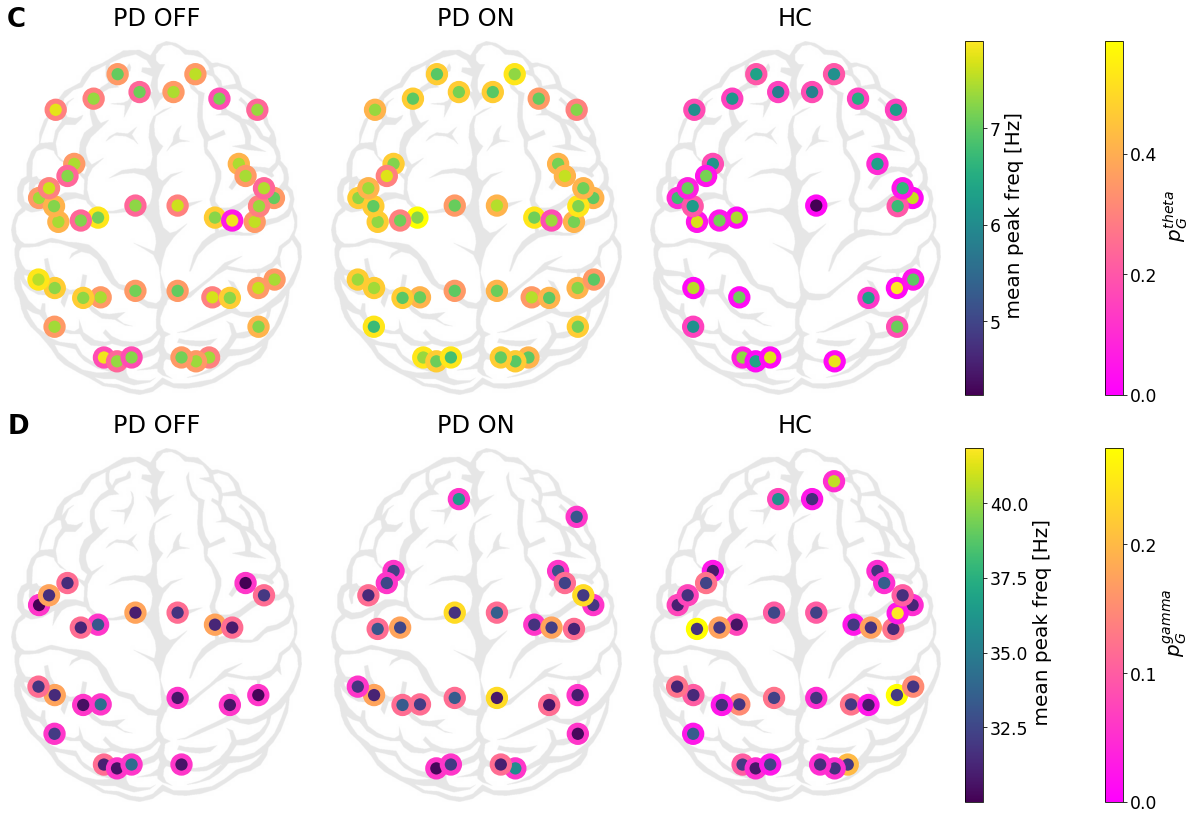

In [36]:
# theta band
avg_data = [t_peak_0,t_peak_1, t_peak_c, g_peak_0,g_peak_1, g_peak_c]
std_data  = [theta_0/17,theta_1/17,theta_c/40,gamma_0/17,gamma_1/17,gamma_c/40]
l_diff_ = [0,1]
title_ = [
            'PD OFF','PD ON', 'HC', 
            ' mean peak freq [Hz]',
            r' $ p_G^{theta}$ ' ,
            'PD OFF','PD ON', 'HC', 
            ' mean peak freq [Hz]',
            r' $ p_G^{gamma}$ ' 
         ]
multiple_brain_plot_projection(x, y, avg_data, std_data, l_diff_, title_, 'freq', type_col = 'freq')



Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'
Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'


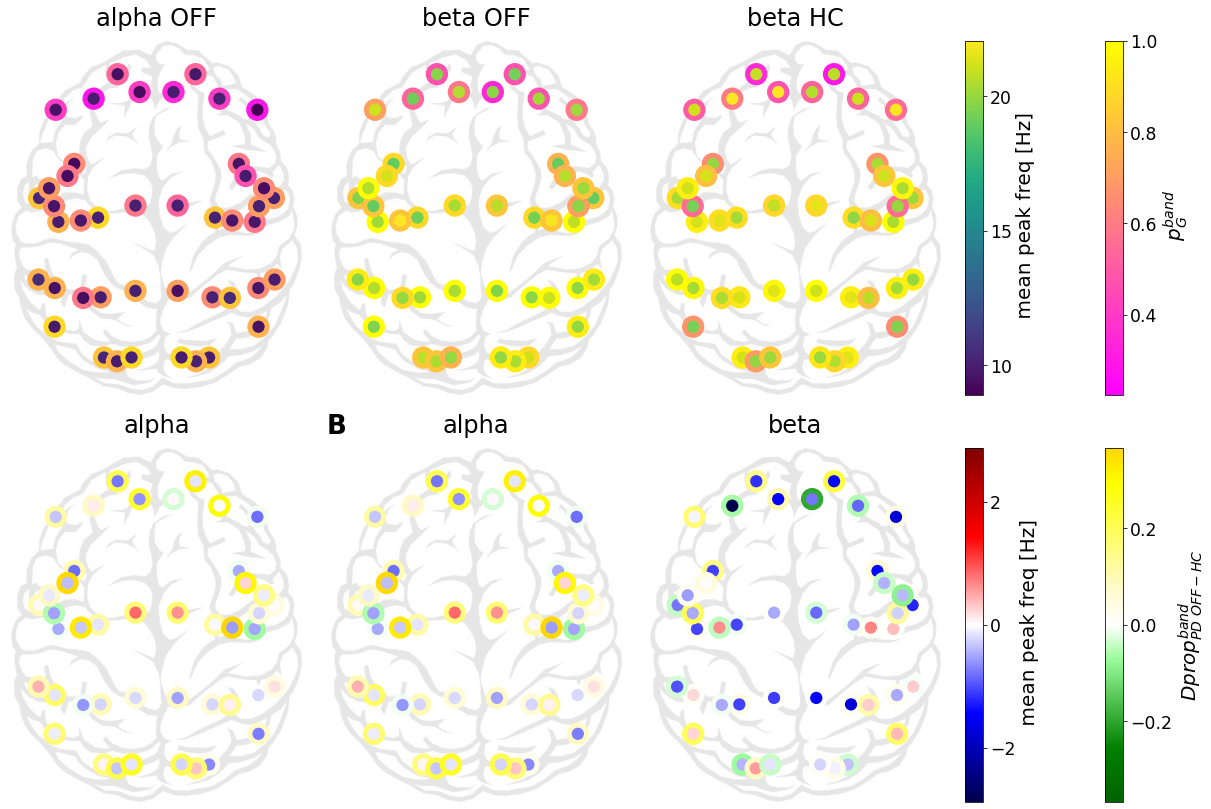

In [37]:
# diff alpha and beta band
avg_data = [a_peak_0, b_peak_0, b_peak_c, a_peak_c]
std_data  = [alpha_0/17,beta_0/17,beta_c/40,alpha_c/40]
l_diff_ = [0,3,0,3,1,2]
title_ = [
            'alpha OFF','beta OFF', 'beta HC', 
            ' mean peak freq [Hz]',
            r' $ p_G^{band}$ ' ,
            'alpha','alpha', 'beta', 
            ' mean peak freq [Hz]',
            r'$ {Dprop}_{PD \ OFF - HC}^{band} $'
         ]
multiple_brain_plot_projection(x, y, avg_data, std_data, l_diff_, title_, 'freq-diff', type_col = 'freq-diff')



## Mean over time

Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'
Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'


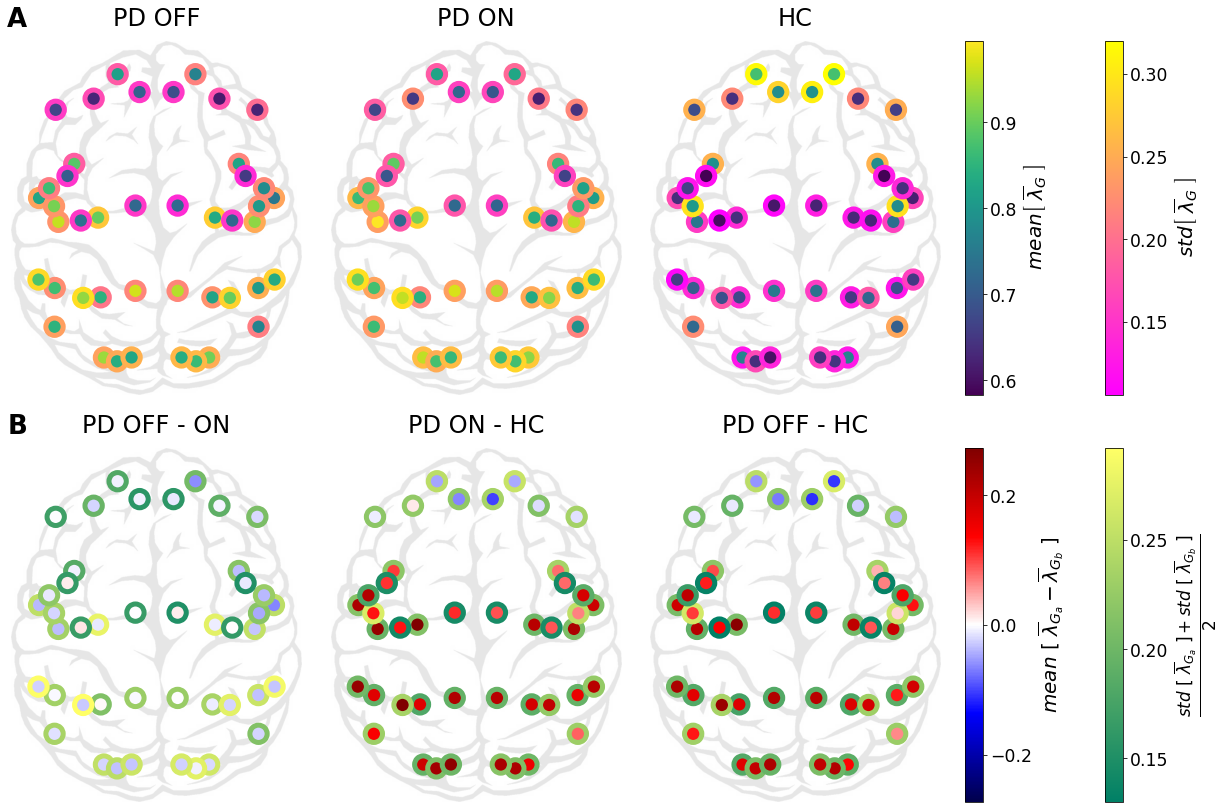

In [28]:
avg_data = [mean_off.mean(axis=0), mean_on.mean(axis=0), mean_c.mean(axis=0)]
std_data  = [mean_off.std(axis=0), mean_on.std(axis=0), mean_c.std(axis=0)]
l_diff_ = [0,1,1,2,0,2]
title_ = [
            'PD OFF','PD ON', 'HC', 
            r' $ mean \left[\ \overline{\lambda}_{G} \ \right]$ ',
            r' $ std \left[\ \overline{\lambda}_{G} \ \right]$ ' ,
            'PD OFF - ON', 'PD ON - HC', 'PD OFF - HC',
            r'$ mean\ [\ \overline{\lambda}_{G_a} - \overline{\lambda}_{G_b}\ ] $',
            r'$ \frac{std\ [\ \overline{\lambda}_{G_a}\ ] + std\ [\ \overline{\lambda}_{G_b}\ ]}{2} $'
         ]
multiple_brain_plot_projection(x, y, avg_data, std_data, l_diff_, title_, 'mean', type_col = 'std',size_std_diff=24)


## PD OFF p-value

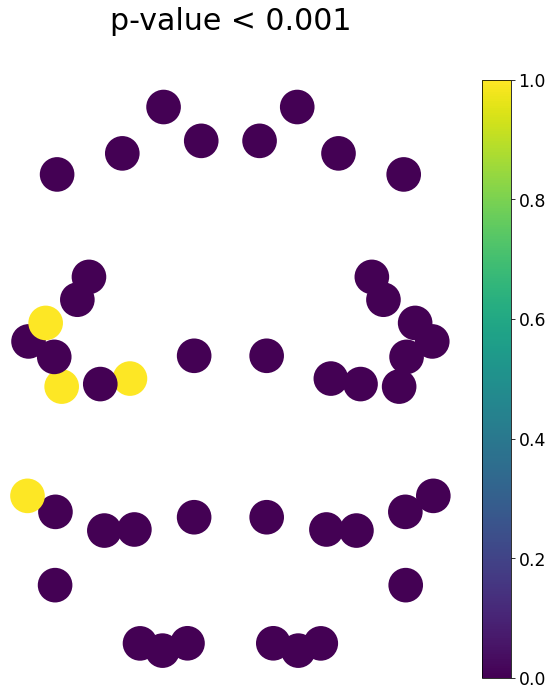

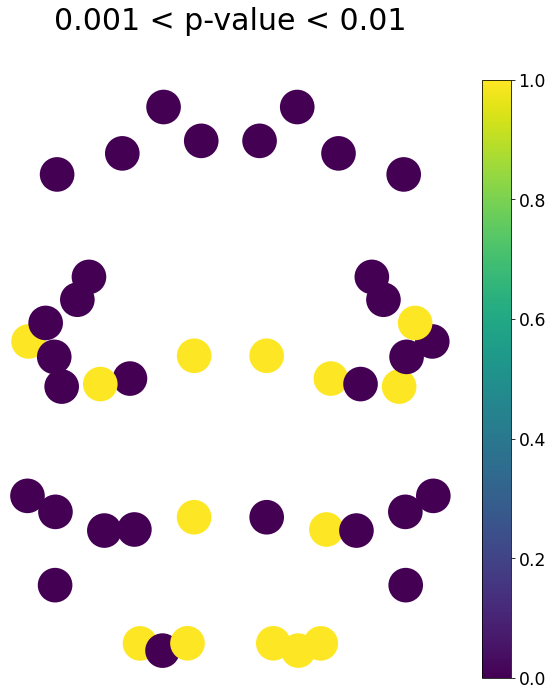

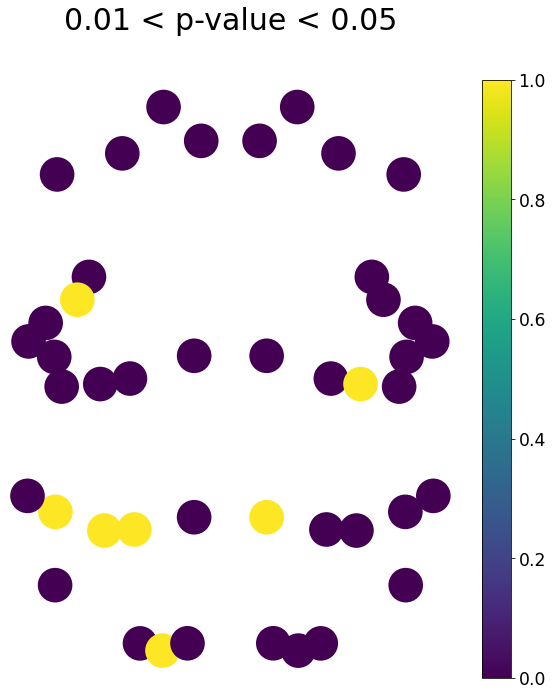

In [29]:
ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[0])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = p_val<0.001
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('p-value < 0.001', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-mean-001.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[0])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.01) & (p_val>0.001)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('0.001 < p-value < 0.01', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-mean-01.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[0])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.05) & (p_val>0.01)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
title('0.01 < p-value < 0.05', pad = 50, size = 30)
axis('off')
clb = colorbar(brain_exp)

savefig('figures/brain/p-values-mean-05.pdf',bbox_inches='tight', format='pdf')


## PD ON p-value

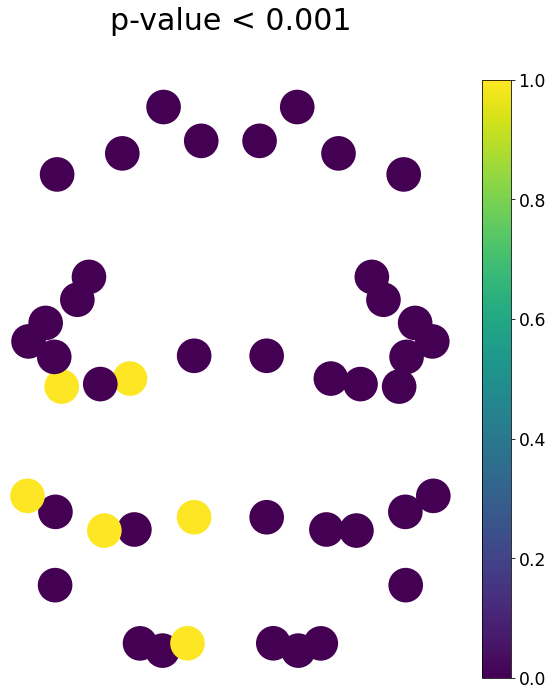

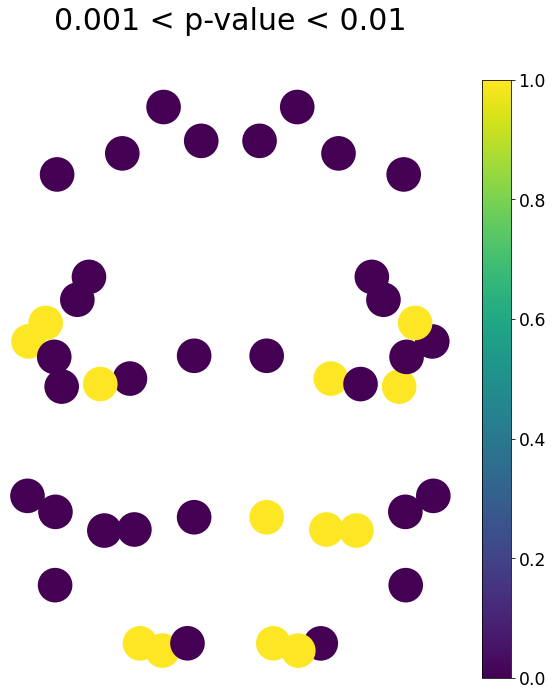

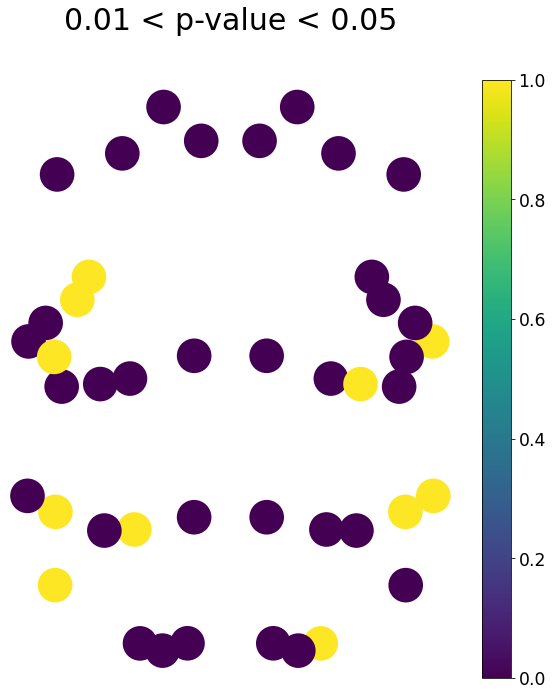

In [30]:
ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[1])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = p_val<0.001
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('p-value < 0.001', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-mean-ON-001.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[1])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.01) & (p_val>0.001)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('0.001 < p-value < 0.01', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-mean-ON-01.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp(array(mean_exps[1])[:,k], array(mean_exps[2]+mean_exps[3])[:,k],alternative='less')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.05) & (p_val>0.01)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
title('0.01 < p-value < 0.05', pad = 50, size = 30)
axis('off')
clb = colorbar(brain_exp)

savefig('figures/brain/p-values-mean-ON-05.pdf',bbox_inches='tight', format='pdf')

## CV over time

Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'
Traceback (most recent call last):
  File "/Users/pascal.helson/opt/anaconda3/envs/mne/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_42485/1738436199.py", line 139, in update_labels
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
AttributeError: 'FigureCanvasPdf' object has no attribute 'get_renderer'


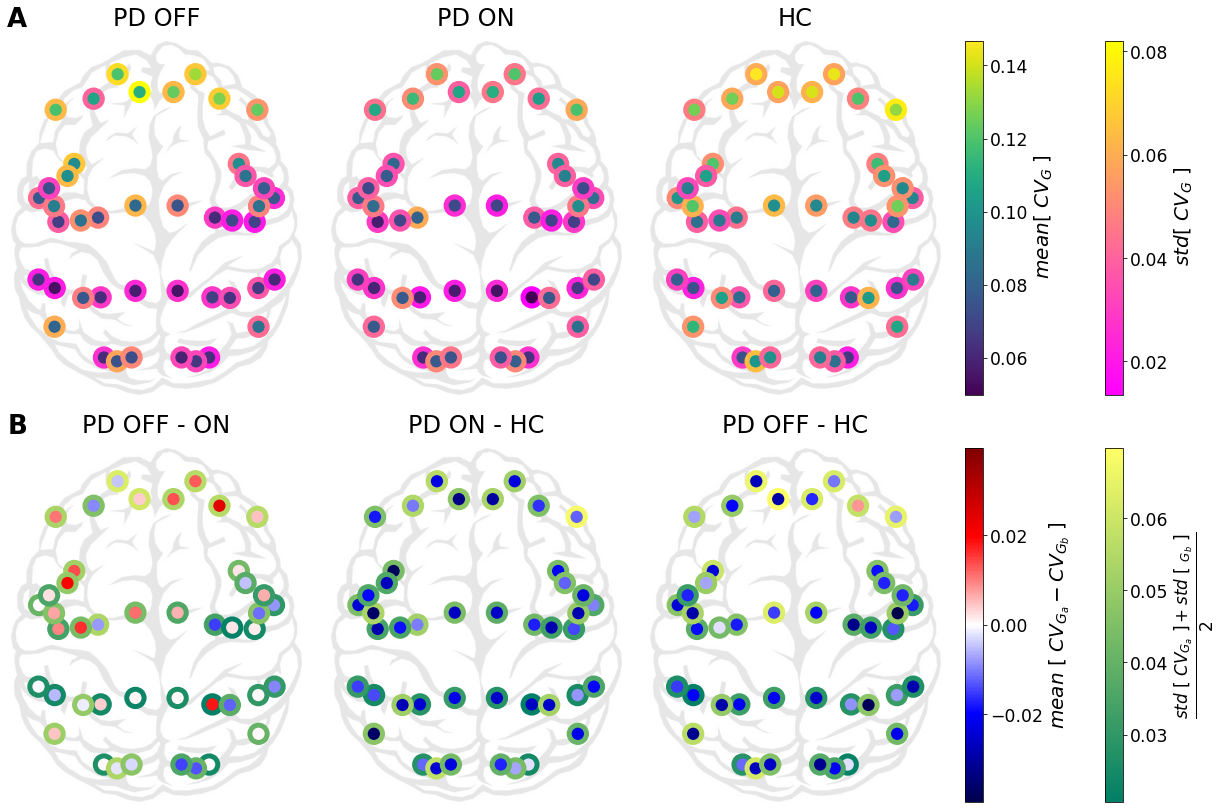

In [40]:
avg_data = [(std_off/mean_off).mean(axis=0), (std_on/mean_on).mean(axis=0), (std_c/mean_c).mean(axis=0)]
std_data  = [(std_off/mean_off).std(axis=0), (std_on/mean_on).std(axis=0), (std_c/mean_c).std(axis=0)]
l_diff_ = [0,1,1,2,0,2]
title_ = [
            'PD OFF','PD ON', 'HC', 
            r' $ mean \left[\ CV_{G} \ \right]$ ',
            r' $ std \left[\ CV_{G}\ \right]$ ' ,
            'PD OFF - ON', 'PD ON - HC', 'PD OFF - HC',
            r'$ mean\ [\ CV_{G_a} - CV_{G_b}\ ] $',
            r'$ \frac{std\ [\ CV_{G_a}\ ] + std\ [\ _{G_b}\ ]}{2} $'
         ]
multiple_brain_plot_projection(x, y, avg_data, std_data, l_diff_, title_, 'CV', type_col = 'std',size_std_diff=24)


## p-value CV PD OFF

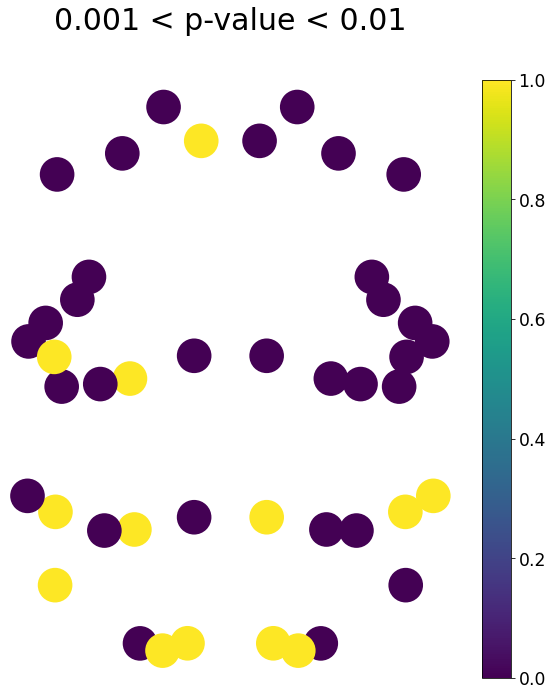

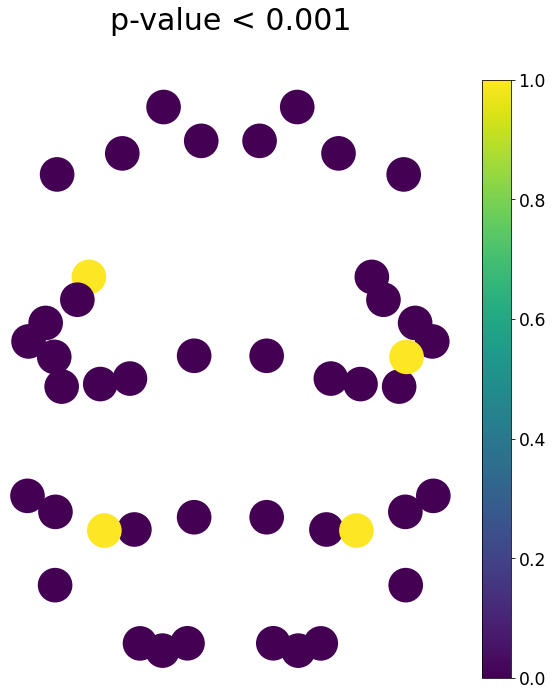

In [34]:
ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp((array(std_exps[0]) / array(mean_exps[0]))[:,k], 
                                    ( array(std_exps[2]+std_exps[3]) / array(mean_exps[2]+mean_exps[3]))[:,k],alternative='greater')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.01) & (p_val>0.001)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('0.001 < p-value < 0.01', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-cv-OFF-01.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp((array(std_exps[0]) / array(mean_exps[0]))[:,k], 
                                    ( array(std_exps[2]+std_exps[3]) / array(mean_exps[2]+mean_exps[3]))[:,k],alternative='greater')
    ks[k,0] = ks_stat
    ks[k,1] = p_val<0.001
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('p-value < 0.001', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-cv-OFF-001.pdf',bbox_inches='tight', format='pdf')

## p-value CV PD ON

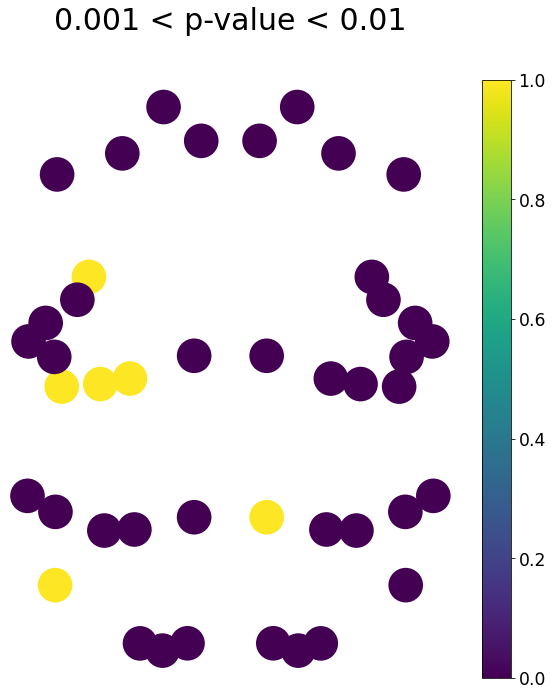

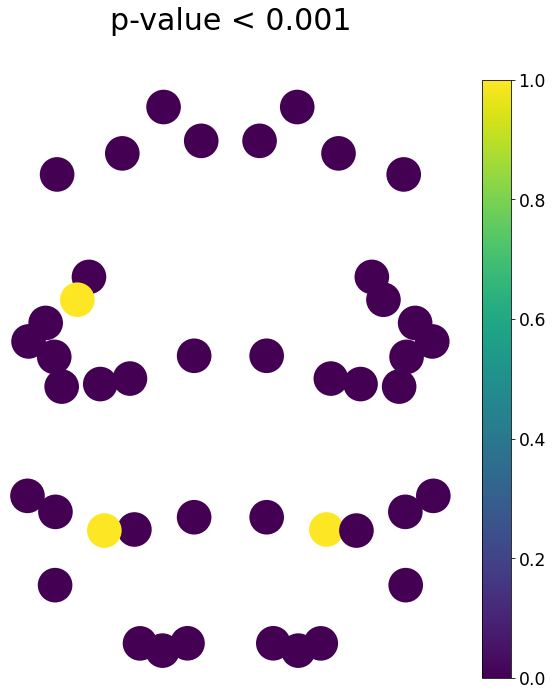

In [35]:
ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp((array(std_exps[1]) / array(mean_exps[1]))[:,k], 
                                    ( array(std_exps[2]+std_exps[3]) / array(mean_exps[2]+mean_exps[3]))[:,k],alternative='greater')
    ks[k,0] = ks_stat
    ks[k,1] = (p_val<0.01) & (p_val>0.001)
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('0.001 < p-value < 0.01', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-cv-ON-01.pdf',bbox_inches='tight', format='pdf')

ks = zeros((44,2))
for k in range(0,44):
    ks_stat, p_val = stats.ks_2samp((array(std_exps[1]) / array(mean_exps[1]))[:,k], 
                                    ( array(std_exps[2]+std_exps[3]) / array(mean_exps[2]+mean_exps[3]))[:,k],alternative='greater')
    ks[k,0] = ks_stat
    ks[k,1] = p_val<0.001
plt.figure(figsize=(10,11))
brain_exp = scatter(-x,y,s=1000,c=ks[:,1], linewidth=3)
axis('off')
title('p-value < 0.001', pad = 50, size = 30)
clb = colorbar(brain_exp)
savefig('figures/brain/p-values-cv-ON-001.pdf',bbox_inches='tight', format='pdf')

## Partial distance correlations with age and UPDRS

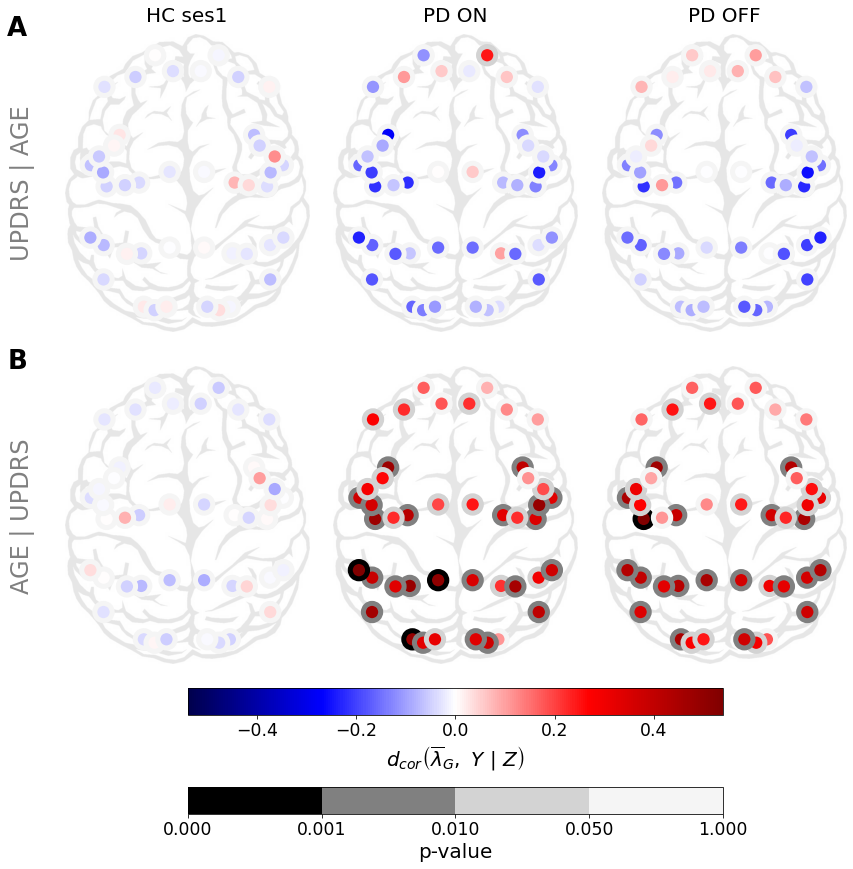

In [71]:
pcor = [[data_pcorr_age_updrs['dcorr'][3],data_pcorr_age_updrs['dcorr'][1],data_pcorr_age_updrs['dcorr'][2]],
        [data_pcorr_age_updrs['dcorr'][7],data_pcorr_age_updrs['dcorr'][6],data_pcorr_age_updrs['dcorr'][5]]]
img = plt.imread("brain_background.jpg")
n_rows = 4
n_cols = 3
#gs = gridspec.GridSpec(n_rows, n_cols)
gs = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,1,1])
avg_cmap = 'seismic'
std_cmap = mpl.colors.ListedColormap(['black', 'gray','lightgray', 'whitesmoke'])
std_norm = mpl.colors.BoundaryNorm([0.,0.001,0.01,0.05,1.], std_cmap.N)
title_ = ['HC ses1', 'PD ON', 'PD OFF']
label_list = ['A','B']
pcorr_ = max([max([max(abs(pcor[i][k][:,0])) for k in range(3)]) for i in range(2)])
pcorr_min = - pcorr_
pcorr_max = pcorr_

fig = figure(figsize = (14,14.5), clear=True, facecolor='None' )
subplots_adjust( hspace = 0.1, wspace = 0.1 )
#ax = ax.ravel()
l_name_method = ['UPDRS | AGE','AGE | UPDRS']

for k in range(len(pcor)):
    n_r = k
    for n_c in range(3):
        ax1 = fig.add_subplot(gs[n_r, n_c])
        avg_data = pcor[k][n_c][:,0]
        #std_data = 2 - 1.*(val[k][:,1]<p_v1) - 1.*(val[k][:,1]<p_v2)
        std_data = pcor[k][n_c][:,1]
        my_normed_data = std_norm(std_data)
        ec_colors = std_cmap(my_normed_data) # a Nx4 array of rgba value
        ax1.scatter( -x, y, s = 300, c = avg_data, edgecolors = ec_colors,linewidth = 5,
                                                vmin = pcorr_min, vmax = pcorr_max, cmap = avg_cmap )
        lim_ = 15
        ax1.set_xlim(min(-x)-lim_,max(-x)+lim_)
        ax1.set_ylim(min(y)-lim_,max(y)+lim_)
        if n_r == 0:
            ax1.set_title(title_[n_c], size = 20, pad = -5)
        # Create second axes
        ax4 = fig.add_subplot(n_rows,n_cols,3*k+n_c+1, label="ax4")
        # Add image to twin axes
        ax4.imshow(img,alpha=0.1, extent=[0,82,0,100])
        # Fix zorder so ax3 on top of ax4
        ax1.set_zorder(10)
        ax4.set_zorder(1)
        # Turn off ticks and spine keeping ylabel
        if n_c==0:
            ax1.set_ylabel(l_name_method[n_r],color='gray',size=24, labelpad=30)
            # adding enumeration of the figures
            #fig.canvas.draw()
            scaledtrans = transforms.ScaledTranslation(-0.8, 4.5, fig.dpi_scale_trans)
            #bbox = ax1.get_tightbbox(fig.canvas.get_renderer())
            ax1.text(0, 0, label_list[n_r], fontsize=26, fontweight="bold", va="top", ha="left",
                   transform=ax1.transAxes + scaledtrans)
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_facecolor("none")
        ax4.set_yticklabels([])
        ax4.set_xticklabels([])
        ax4.set_xticks([])
        ax4.set_yticks([])
        for where in ['top', 'bottom', 'left', 'right']:
            ax1.spines[where].set_visible(False)
            ax4.spines[where].set_visible(False)

# plotting colorbars
gs2 = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,1,1], hspace=0.35)
ax_cb1 = fig.add_subplot(gs2[n_rows-2, :], label="ax_cb1")
ax_cb2 = fig.add_subplot(gs2[n_rows-1, :], label="ax_cb2")
norm = mpl.colors.Normalize(vmin=pcorr_min,vmax=pcorr_max)
cbar = ax_cb1.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=avg_cmap), ax=ax_cb1, orientation='horizontal',
                                fraction=0.6, pad=0.)
cbar.set_label(label=r'$d_{cor}\left(\overline{\lambda}_G,\ Y\ |\ Z\right)$', size=20)
cbar = ax_cb2.figure.colorbar(mpl.cm.ScalarMappable(norm=std_norm, cmap = std_cmap), ax=ax_cb2,orientation='horizontal',
                             fraction=0.6, pad=0.)
cbar.ax.get_yaxis().set_ticks([])
#for j, lab in enumerate(['$<0.001$','$<0.01$','$>0.01$']):
#    cbar.ax.text(0. + 0.5*(j==0) , 0. + (2 * j + 1) / 8.0, lab, ha='center', va='center', size = 18)
cbar.ax.get_yaxis().labelpad = 80
cbar.set_label(label='p-value', size=20)
ax_cb1.axis('off')
ax_cb2.axis('off')
#savefig('figures/brain/pdcorr_updrs_age_2.pdf',bbox_inches='tight', format='pdf')
show()

## Distance, Pearson and Spearman partial correlation with UPDRS

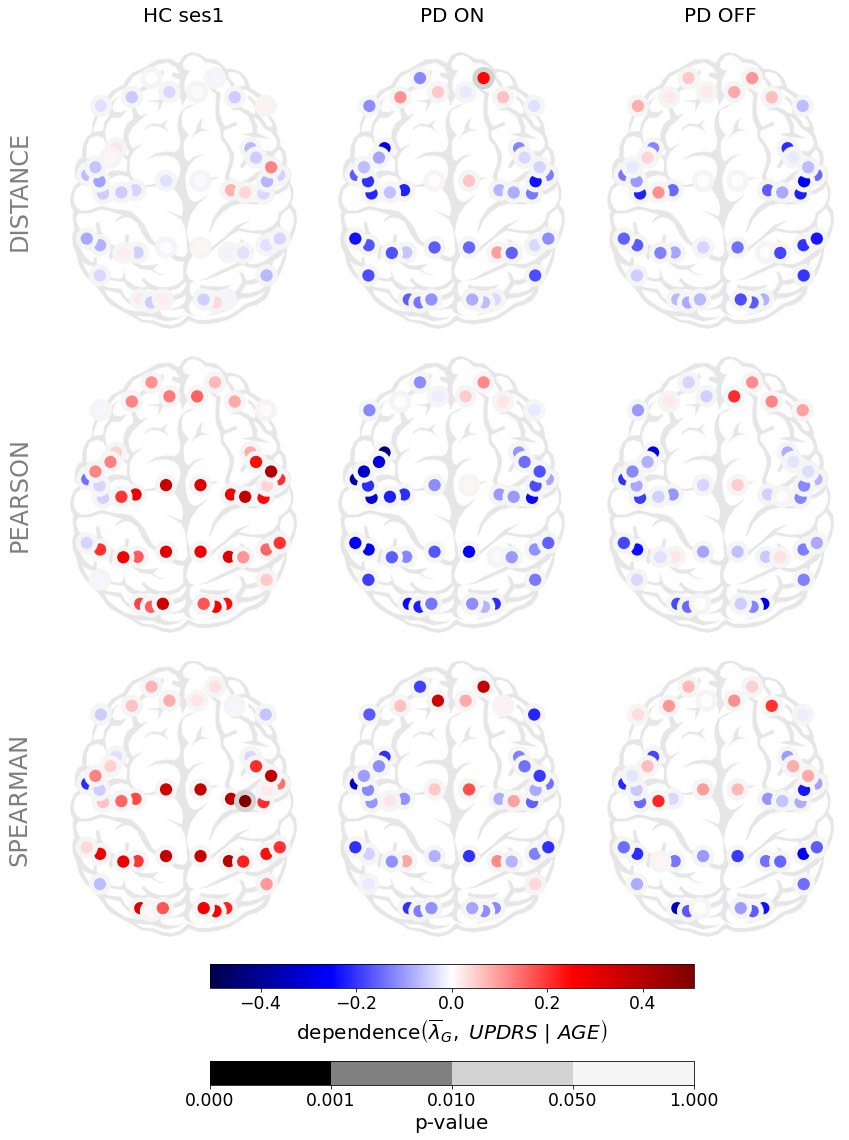

In [72]:
img = plt.imread("brain_background.jpg")
n_rows = 5
n_cols = 3
#gs = gridspec.GridSpec(n_rows, n_cols)
gs = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,6,1,1])
counter = 0
n_corr  = -1
avg_cmap = 'seismic'
std_cmap = mpl.colors.ListedColormap(['black', 'gray','lightgray', 'whitesmoke'])
std_norm = mpl.colors.BoundaryNorm([0.,0.001,0.01,0.05,1.], std_cmap.N)
p_v1 = 0.01
p_v2 = 0.001
title_ = ['HC ses1', 'PD ON', 'PD OFF']
pcorr_min = 1
pcorr_max = -1
ind_pcorr = [3,1,2]
for val in data_pcorr_age_updrs.values():
    pcorr_min = min( pcorr_min, min([min(val[k][:,0]) for k in ind_pcorr]) )
    pcorr_max = max( pcorr_max, max([max(val[k][:,0]) for k in ind_pcorr]) )
pcorr_ = max(abs(pcorr_min),abs(pcorr_max))
pcorr_min = - pcorr_
pcorr_max = pcorr_

fig = figure(figsize = (14,19), clear=True, facecolor='None' )
subplots_adjust( hspace = 0.15, wspace = 0.1 )
#ax = ax.ravel()
name_method = {}
corr_method = ['dcorr','pearson','spearman']
l_name_method = ['DISTANCE','PEARSON','SPEARMAN']
for k in range(0,3):
    name_method[corr_method[k]] = l_name_method[k]

for cle,val in data_pcorr_age_updrs.items():
    in_count = 0
    n_corr += 1
    for k in ind_pcorr:
        counter += 1
        ax1 = fig.add_subplot(gs[n_corr, in_count])
        avg_data = val[k][:,0]
        #std_data = 2 - 1.*(val[k][:,1]<p_v1) - 1.*(val[k][:,1]<p_v2)
        std_data = val[k][:,1]
        my_normed_data = std_norm(std_data)
        ec_colors = std_cmap(my_normed_data) # a Nx4 array of rgba value
        ax1.scatter( -x, y, s = 300, c = avg_data, edgecolors = ec_colors,linewidth = 5,
                                                vmin = pcorr_min, vmax = pcorr_max, cmap = avg_cmap )
        lim_ = 15
        ax1.set_xlim(min(-x)-lim_,max(-x)+lim_)
        ax1.set_ylim(min(y)-lim_,max(y)+lim_)
        if counter<4:
            ax1.set_title(title_[in_count], size = 20, pad = 30)
        # Create second axes
        ax4 = fig.add_subplot(n_rows,n_cols,counter, label="ax4")
        # Add image to twin axes
        ax4.imshow(img,alpha=0.1, extent=[0,82,0,100])
        # Fix zorder so ax3 on top of ax4
        ax1.set_zorder(10)
        ax4.set_zorder(1)
        # Turn off ticks and spine keeping ylabel
        if in_count==0:
            ax1.set_ylabel(name_method[cle],color='gray',size=24, labelpad=30)
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_facecolor("none")
        ax4.set_yticklabels([])
        ax4.set_xticklabels([])
        ax4.set_xticks([])
        ax4.set_yticks([])
        for where in ['top', 'bottom', 'left', 'right']:
            ax1.spines[where].set_visible(False)
            ax4.spines[where].set_visible(False)
        #ax4.set_xticks([])
        #ax4.set_yticks([])
        #ax1.set_xticks([])
        #ax1.set_yticks([])
        in_count += 1
    
# plotting colorbars
gs2 = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,6,1,1], hspace=0.35)
ax_cb1 = fig.add_subplot(gs2[3, :], label="ax_cb1")
ax_cb2 = fig.add_subplot(gs2[4, :], label="ax_cb2")
norm = mpl.colors.Normalize(vmin=pcorr_min,vmax=pcorr_max)
cbar = ax_cb1.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=avg_cmap), ax=ax_cb1, orientation='horizontal',
                                fraction=0.6, pad=0.)
cbar.set_label(label='dependence'+r'$\left(\overline{\lambda}_G,\ UPDRS\ |\ AGE\right)$', size=20)
cbar = ax_cb2.figure.colorbar(mpl.cm.ScalarMappable(norm=std_norm, cmap = std_cmap), ax=ax_cb2,orientation='horizontal',
                             fraction=0.6, pad=0.)
cbar.ax.get_yaxis().set_ticks([])
#for j, lab in enumerate(['$<0.001$','$<0.01$','$>0.01$']):
#    cbar.ax.text(0. + 0.5*(j==0) , 0. + (2 * j + 1) / 8.0, lab, ha='center', va='center', size = 18)
cbar.ax.get_yaxis().labelpad = 80
cbar.set_label(label='p-value', size=20)
ax_cb1.axis('off')
ax_cb2.axis('off')
#savefig('figures/brain/UPDRS' + method + 'partial_correlation.pdf',bbox_inches='tight', format='pdf')
show()

## Distance, Pearson and Spearman partial correlation with age

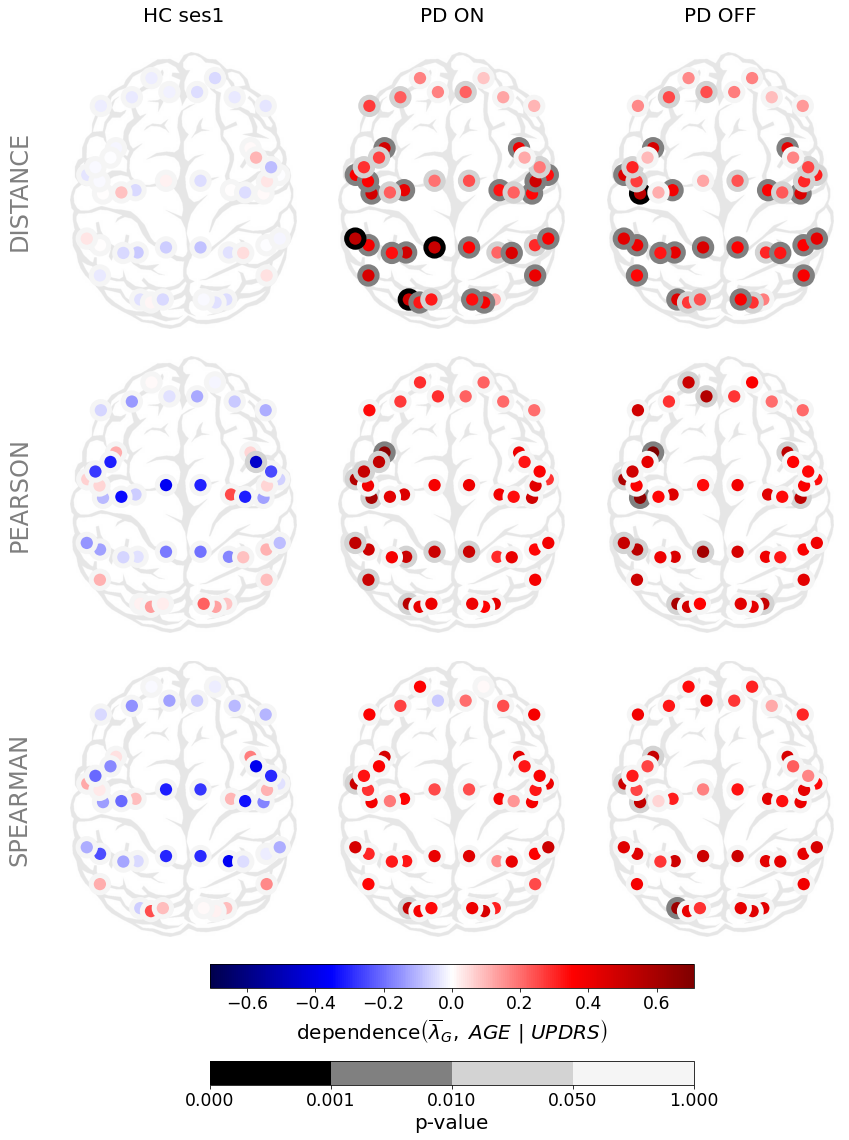

In [73]:
img = plt.imread("brain_background.jpg")
n_rows = 5
n_cols = 3
#gs = gridspec.GridSpec(n_rows, n_cols)
gs = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,6,1,1])
counter = 0
n_corr  = -1
avg_cmap = 'seismic'
std_cmap = mpl.colors.ListedColormap(['black', 'gray','lightgray', 'whitesmoke'])
std_norm = mpl.colors.BoundaryNorm([0.,0.001,0.01,0.05,1.], std_cmap.N)
p_v1 = 0.01
p_v2 = 0.001
title_ = ['HC ses1', 'PD ON', 'PD OFF']
pcorr_min = 1
pcorr_max = -1
ind_pcorr = [7,6,5]
for val in data_pcorr_age_updrs.values():
    pcorr_min = min( pcorr_min, min([min(val[k][:,0]) for k in ind_pcorr]) )
    pcorr_max = max( pcorr_max, max([max(val[k][:,0]) for k in ind_pcorr]) )
pcorr_ = max(abs(pcorr_min),abs(pcorr_max))
pcorr_min = - pcorr_
pcorr_max = pcorr_

fig = figure(figsize = (14,19), clear=True, facecolor='None' )
subplots_adjust( hspace = 0.15, wspace = 0.1 )
#ax = ax.ravel()
name_method = {}
corr_method = ['dcorr','pearson','spearman']
l_name_method = ['DISTANCE','PEARSON','SPEARMAN']
for k in range(0,3):
    name_method[corr_method[k]] = l_name_method[k]

for cle,val in data_pcorr_age_updrs.items():
    in_count = 0
    n_corr += 1
    for k in ind_pcorr:
        counter += 1
        ax1 = fig.add_subplot(gs[n_corr, in_count])
        avg_data = val[k][:,0]
        #std_data = 2 - 1.*(val[k][:,1]<p_v1) - 1.*(val[k][:,1]<p_v2)
        std_data = val[k][:,1]
        my_normed_data = std_norm(std_data)
        ec_colors = std_cmap(my_normed_data) # a Nx4 array of rgba value
        ax1.scatter( -x, y, s = 300, c = avg_data, edgecolors = ec_colors,linewidth = 5,
                                                vmin = pcorr_min, vmax = pcorr_max, cmap = avg_cmap )
        lim_ = 15
        ax1.set_xlim(min(-x)-lim_,max(-x)+lim_)
        ax1.set_ylim(min(y)-lim_,max(y)+lim_)
        if counter<4:
            ax1.set_title(title_[in_count], size = 20, pad = 30)
        # Create second axes
        ax4 = fig.add_subplot(n_rows,n_cols,counter, label="ax4")
        # Add image to twin axes
        ax4.imshow(img,alpha=0.1, extent=[0,82,0,100])
        # Fix zorder so ax3 on top of ax4
        ax1.set_zorder(10)
        ax4.set_zorder(1)
        # Turn off ticks and spine keeping ylabel
        if in_count==0:
            ax1.set_ylabel(name_method[cle],color='gray',size=24, labelpad=30)
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_facecolor("none")
        ax4.set_yticklabels([])
        ax4.set_xticklabels([])
        ax4.set_xticks([])
        ax4.set_yticks([])
        for where in ['top', 'bottom', 'left', 'right']:
            ax1.spines[where].set_visible(False)
            ax4.spines[where].set_visible(False)
        #ax4.set_xticks([])
        #ax4.set_yticks([])
        #ax1.set_xticks([])
        #ax1.set_yticks([])
        in_count += 1
    
# plotting colorbars
gs2 = gridspec.GridSpec(n_rows, n_cols, height_ratios=[6,6,6,1,1], hspace=0.35)
ax_cb1 = fig.add_subplot(gs2[3, :], label="ax_cb1")
ax_cb2 = fig.add_subplot(gs2[4, :], label="ax_cb2")
norm = mpl.colors.Normalize(vmin=pcorr_min,vmax=pcorr_max)
cbar = ax_cb1.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=avg_cmap), ax=ax_cb1, orientation='horizontal',
                                fraction=0.6, pad=0.)
cbar.set_label(label='dependence'+r'$\left(\overline{\lambda}_G,\ AGE \ | \ UPDRS \right)$', size=20)
cbar = ax_cb2.figure.colorbar(mpl.cm.ScalarMappable(norm=std_norm, cmap = std_cmap), ax=ax_cb2,orientation='horizontal',
                             fraction=0.6, pad=0.)
cbar.ax.get_yaxis().set_ticks([])
#for j, lab in enumerate(['$<0.001$','$<0.01$','$>0.01$']):
#    cbar.ax.text(0. + 0.5*(j==0) , 0. + (2 * j + 1) / 8.0, lab, ha='center', va='center', size = 18)
cbar.ax.get_yaxis().labelpad = 80
cbar.set_label(label='p-value', size=20)
ax_cb1.axis('off')
ax_cb2.axis('off')
#savefig('figures/brain/age_' + method + 'partial_correlation.pdf',bbox_inches='tight', format='pdf')
show()

# ---------------------------------------------------------
# ---------------------------------------------------------
# ------------------ PLOTS END ------------------------
# ---------------------------------------------------------
# ---------------------------------------------------------